In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_directory = os.path.join(PATH , 'train')
validation_directory = os.path.join(PATH , 'validation')
Batch_size = 32
Img_size = (224 , 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory , shuffle= True, batch_size= Batch_size, image_size= Img_size)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory, shuffle= True, batch_size= Batch_size, image_size= Img_size)

Found 1000 files belonging to 2 classes.


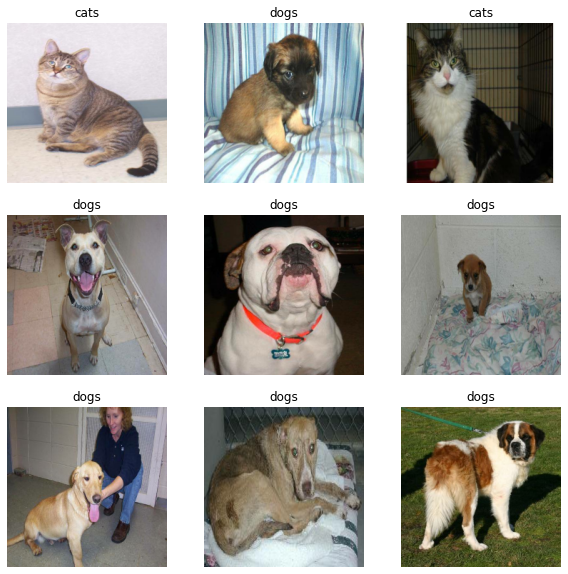

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize = (10 , 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
num_val_batches = tf.data.experimental.cardinality(validation_dataset )
test_dataset = validation_dataset.take(num_val_batches // 5)
validation_dataset = validation_dataset.skip(num_val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
Autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=Autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=Autotune)
test_dataset = test_dataset.prefetch(buffer_size=Autotune)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),

])

In [ ]:
base_model = tf.keras.applications.VGG19( input_tensor=None,input_shape=(224, 224, 3),
                                         include_top = False,
                                         weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
base_model.trainable = False


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                           

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 6s 178ms/step - loss: 1.9593 - accuracy: 0.5953


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.96
initial accuracy: 0.60


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 21s 307ms/step - loss: 1.9273 - accuracy: 0.5845 - val_loss: 1.9028 - val_accuracy: 0.6436
Epoch 2/10
63/63 [==============================] - 19s 295ms/step - loss: 1.6794 - accuracy: 0.6095 - val_loss: 1.5092 - val_accuracy: 0.6980
Epoch 3/10
63/63 [==============================] - 19s 292ms/step - loss: 1.3931 - accuracy: 0.6425 - val_loss: 1.1853 - val_accuracy: 0.7426
Epoch 4/10
63/63 [==============================] - 19s 290ms/step - loss: 1.3439 - accuracy: 0.6715 - val_loss: 1.0418 - val_accuracy: 0.7686
Epoch 5/10
63/63 [==============================] - 19s 291ms/step - loss: 1.1206 - accuracy: 0.7030 - val_loss: 0.9090 - val_accuracy: 0.7896
Epoch 6/10
63/63 [==============================] - 19s 293ms/step - loss: 1.0904 - accuracy: 0.7155 - val_loss: 0.8458 - val_accuracy: 0.8057
Epoch 7/10
63/63 [==============================] - 19s 292ms/step - loss: 0.9842 - accuracy: 0.7345 - val_loss: 0.6881 - val_accuracy: 0.8255

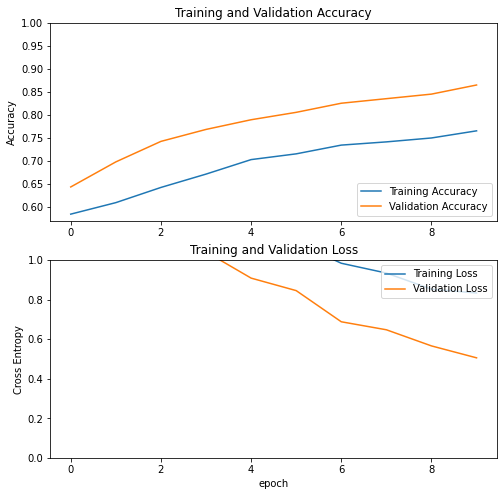

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                           

In [ ]:
len(model.trainable_variables)

34

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 42s 632ms/step - loss: 0.3713 - accuracy: 0.8685 - val_loss: 0.1978 - val_accuracy: 0.9344
Epoch 11/20
63/63 [==============================] - 40s 628ms/step - loss: 0.1678 - accuracy: 0.9375 - val_loss: 0.0710 - val_accuracy: 0.9752
Epoch 12/20
63/63 [==============================] - 41s 641ms/step - loss: 0.1227 - accuracy: 0.9510 - val_loss: 0.0432 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 40s 628ms/step - loss: 0.1254 - accuracy: 0.9510 - val_loss: 0.0510 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 40s 628ms/step - loss: 0.0932 - accuracy: 0.9605 - val_loss: 0.0645 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 40s 627ms/step - loss: 0.0844 - accuracy: 0.9680 - val_loss: 0.0608 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 40s 626ms/step - loss: 0.0632 - accuracy: 0.9710 - val_loss: 0.0790 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

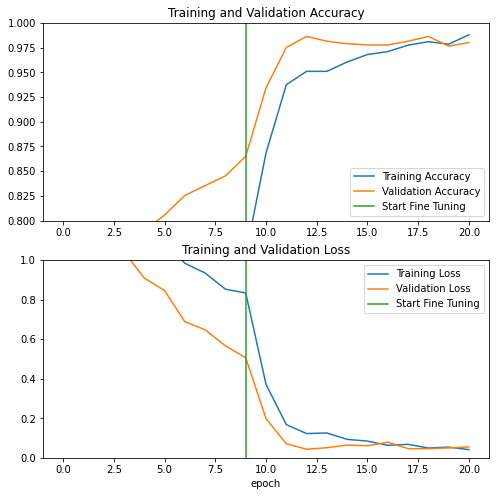

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 185ms/step - loss: 0.0491 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0]
Labels:
 [0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0]


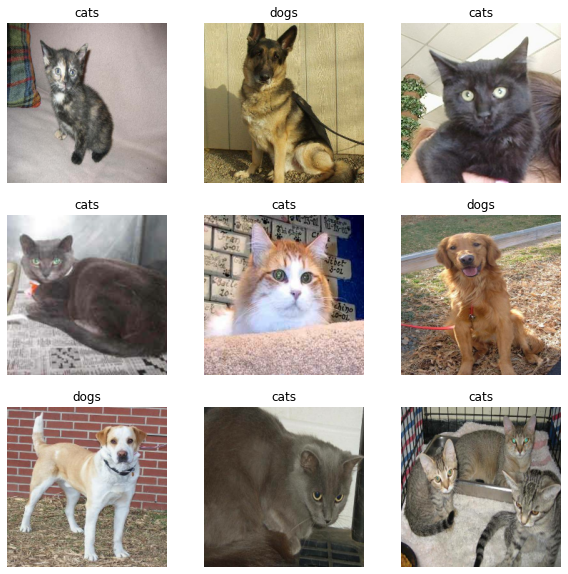

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")